The Gurney flap is a small plate attached to or near the trailing edge of an airfoil, perpendicular to the flow on the pressure side.
Being counterintuitive to the idea of a streamlined body, the Gurney flap was invented more or less accidentally by race car driver Dan Gurney.

There are two basic (and somewhat overlapping) explanations for the lift-enhancing effect:

- The flap effectively increases camber [1], decelerating flow on the pressure side and accelerating flow on the suction side.
- The flap decelerates the flow on the pressure side right until the edge and leads to a pressure difference between suction and pressure side which in turn leads to an increased circulation [2].

However, the flow is rather complex and includes unsteady vortex-shedding[3] at the trailing edge.

To model the effects of a Gurney flap with viiflow, a single virtual displacement element is used depending on the position of the Gurney flap. 
The effect of Gurney flap position and height is analyzed and compared to the experimental results.
As far as the author knows, this is the first numerical analysis of Gurney flaps using a panel method.
The possibility of modeling the effect of a Gurney flap using a change in the Kutta condition of a panel method has been proposed in [2], but no function that correlates the Kutta condition (or a step in pressure) to the Gurney flap height is given.

The effect of Gurney flaps on the lift of an airfoil are surprisingly well predicted with viiflow.
This does not hold for the drag, though.
The drag increase for Gurney flaps that are not at the trailing edge can be computed with similar accuracy compared to a fully-turbulent RANS solution, but the coefficients were significantly overpredicted. 
For Gurney flaps right at the trailing edge, the drag cannot be computed using the wake boundary layer at this point, and the additional drag due to the Gurney flap is estimated using the local pressure at the flap.


## Experiments
The most comprehensive experimental analysis to date on an airfoil can be found in [7] where the S903 airfoil has been analyzed.
The coordinates of the airfoil can be found in [8], the paneling has been increased near the trailing edge.
Gurney flap position, height and influence of transition location have been evaluated.
In [4] some of these experimental results are compared with computational results with a fully-turbulent RANS solver. 
A note on these experimental results: the legend in the drag polar plot in [7], Fig. 6, is wrong.
Here, the plots have been changed assuming decreasing drag at higher lift coefficients with decreasing chord position. 

In [6]:
%matplotlib inline
%config InlineBackend.figure_format = 'svg'
import viiflow as vf
import viiflowtools.vf_tools as vft
import viiflowtools.vf_plots as vfp
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
import os
os.environ["OMP_NUM_THREADS"] = "1"

N = 280 #220 good for gfs/S903RF, 180 good for both, 280 good for both, too
AF = vft.repanel_spline(vft.read_selig("S903RF.dat"),N)

## Results
In all cases, viiflow accurately predicts the increase in lift and change in maximum lift.
The drag coefficient is less accurately predicted.

Where the Gurney flap is right at the trailing edge, the increase in drag is invisible to viiflow without further modifications.
In viiflow, the drag is calculated using the Squire-Young formula using the wake boundary layer development.
The wake boundary layer development depends on its initialization at the trailing edge, which is done by adding the momentum and displacement thickness of suction and pressure side and a weighted average of the shear-stress.
At this point, the modeling of the flow at the trailing edge is insufficient to describe the development of the wake behind a Gurney flap. 
However, the increase in drag seems to be largely dependent on the pressure difference at the Gurney flap [6].
Adding the pressure afterwards to the drag coefficient markedly improves the drag prediction.
In fact, the resulting polar matches the experiments better than the results of a Gurney flap at .9c or .95c.

If the transition is forced early on, the increase in drag matches the results of the RANS calculations better, though still with a significant drag bucket at low AOA. 
Without forced transition, the results do not get closer to the experimental results but vary significantly over the lift coefficient.
Both computational methods overpredict the increase in drag.

In [7]:
# We go through the experiments using the list below,
# using hgv, the vector of gurney flap heights
# and using pchord, the position of the gurney flap

# Virtual displacement
hgv = [0.0,0.005,0.01,0.02,0.02,0.02,0.02,0]
pchord = [1,1,1,1,.95,.9,.9,.9]
forced = [0,0,0,0,0,0,1,1]

pol = []
AOARANGE = []
AOARANGE.append(np.arange(4.5,-13,-0.5))
AOARANGE.append(np.arange(5,18,0.5))

# Go over experiment setup
for i in range(len(hgv)):
    hg = hgv[i] 
    pc = pchord[i]

    # Gurney flap displacement
    vd = 0*AF[0,:]
    if pc>=1.0:
        index_gf = N-1
    else:
        for k in range(1,AF.shape[1]):
            if AF[0,-k]<pc:
                index_gf = N-k
                break
    vd[index_gf] = hg


    # Solver Setup
    RE = 1.0e6
    AOA0 = AOARANGE[0]
    # Not sure why they say "Mach less than 0.2", with the chord length and RE of 1e6 its 0.1.
    Mach = 0.1 
    # ncrit = 8 is a better fit to the end of the drag bucket for the non-gurney airfoil
    s = vf.setup(Re=RE,Ma = Mach,ncrit=8) 
    s.iterate_wakes = False
    s.itermax = 100
    s.silent = True
    # Use incompressible boundary layer calculation.
    s.incompressible_bl = 1


    alv = []
    clv = []
    cdv = []
    cdvg = []
    #print('Calculating Height: %fc, Position: %fc' % (hg,pc) ) 

    for j in range(2): # aoa up and down
        # Set-up and initialize based on inviscid panel solution
        s.alpha = AOARANGE[j][0]
        (p,bl,x) = vf.init(AF,s)
        x[p.foils[0].N::p.foils[0].N+p.wakes[0].N-1]+=vd[-1]
        xn = x.copy()
        if hg>0:
            xtrans = p.foils[0].X[0,index_gf]-0.005
            vf.set_forced_transition(bl,p,[],[xtrans])
            
        if forced[i]:
            vf.set_forced_transition(bl,p,[.02],[.05])
        
        for alpha in AOARANGE[j]:
            s.alpha = alpha

            res = None
            grad = None
            [xn,flag,res,grad,_] = vf.iter(xn,bl,p,s,res,grad,[vd])
            # Plot geometry

            nres=np.sqrt(np.dot(res.T,res))

            if flag:
                # Add to end or start of polar list
                if j == 1:pos = len(alv)
                else: pos = 0
                
                # Add pressure at gf. cp = 1-ue²/2
                # cp_before: 1-0, cpafter: 1-ue²/2, cd: cp_before-cp_after
                ue_gf = bl[0].bl_fl.nodes[index_gf].ue
                cdvg.insert(pos,hg*(0.5*ue_gf**2))

                alv.insert(pos,alpha)
                clv.insert(pos,p.CL)
                cdv.insert(pos,bl[0].CD)
                #print('AL: %f CL: %f CD: %f' % (alpha,p.CL,bl[0].CD) )
            #else:
                #print('Unsolved AOA %f'%alpha)

    pol.append({'CL': np.asarray(clv), 'CD': np.asarray(cdv), 'CDg':np.asarray(cdvg), 'hg': hg, 'al': np.asarray(alv)})


 xi=0.052901,delta=0.010441,theta=0.003983,ue=0.923912,typ=wake,
 res=-5.66382e-08-2.65278-1.75198, dx=3.38365e-09--1.56559e-07--0.084043 lam=0.000000, US=0.999998,HK=2.621526,HS=21.396554.

 xi=0.058201,delta=0.000546,theta=0.000546,ue=1.397910,typ=wake,
 res=-2.78382e-07--6.31288e-08-6.82395e-12, dx=8.38467e-11-6.00942e-08--2.12361e-09 lam=0.000000, US=0.999998,HK=1.000001,HS=1.999999.

 xi=0.006917,delta=0.023885,theta=0.001900,ue=1.045864,typ=wake,
 res=-4.13924e-05-0.292188-3.58819e-05, dx=-3.70074e-07--4.26139e-06-2.44037e-07 lam=1.000000, US=0.249185,HK=2.674620,HS=2.028829.

 xi=0.006917,delta=0.023847,theta=0.001885,ue=1.045762,typ=wake,
 res=0.000259587-0.000452874-4.87394e-08, dx=-2.62397e-07-2.65269e-05--8.4251e-07 lam=1.000000, US=0.186141,HK=2.675762,HS=1.516716.

 xi=0.742538,delta=0.050777,theta=0.019420,ue=1.059692,typ=turbulent,
 res=4.94302e-09-1.19061e-06-4.01276e-10, dx=-7.58657e-07-9.01853e-06--6.82456e-07 lam=1.000000, US=0.193275,HK=2.614666,HS=1.510121.

 xi=0.


 xi=0.975446,delta=0.026760,theta=0.026394,ue=0.472049,typ=turbulent,
 res=-0.000563403-0.010945-0.00245832, dx=0.0140326--0.120497-0.0248497 lam=0.007192, US=0.977992,HK=1.013846,HS=1.988706.

 xi=0.975333,delta=0.026078,theta=0.025040,ue=0.480000,typ=turbulent,
 res=-0.0620102-0.0113008-0.00120271, dx=0.0108621--0.100594-0.0183219 lam=0.183650, US=0.936305,HK=1.041454,HS=1.966938.

 xi=0.975228,delta=0.025545,theta=0.018809,ue=0.555472,typ=turbulent,
 res=-0.0730874-0.0142912-0.00287443, dx=-0.0312887-0.290575--0.0501377 lam=0.200385, US=0.605364,HK=1.358101,HS=1.774441.

 xi=0.975124,delta=0.025152,theta=0.014516,ue=0.634247,typ=turbulent,
 res=-0.0803121-0.0143914-0.000561766, dx=-0.0124649-0.169656--0.022849 lam=0.388194, US=0.401890,HK=1.732641,HS=1.638541.

 xi=0.975517,delta=0.024690,theta=0.024269,ue=0.452270,typ=turbulent,
 res=-0.0102421-0.0117577-0.00211163, dx=0.00621202--0.0559111-0.0130942 lam=0.056634, US=0.972536,HK=1.017360,HS=1.985899.

 xi=0.975312,delta=0.024078,t

 xi=0.977601,delta=0.032581,theta=0.032114,ue=0.527754,typ=turbulent,
 res=-0.000908005-0.0104218-0.00325351, dx=0.639457--4.9949-0.807469 lam=0.000299, US=0.976883,HK=1.014546,HS=1.988110.

 xi=0.977452,delta=0.031285,theta=0.023399,ue=0.607243,typ=turbulent,
 res=-0.0351365-0.00925304-0.000273599, dx=0.00405686--0.0401362-0.00514559 lam=1.000000, US=0.621097,HK=1.337018,HS=1.783981.

 xi=0.977748,delta=0.033162,theta=0.032739,ue=0.503474,typ=turbulent,
 res=-5.70386e-05-0.011679-0.0029255, dx=0.0178304--0.132129-0.0251129 lam=0.002075, US=0.979403,HK=1.012935,HS=1.989415.

 xi=0.977560,delta=0.031435,theta=0.030991,ue=0.516272,typ=turbulent,
 res=-7.38382e-05-0.0106885-0.00275539, dx=0.0310472--0.247363-0.0427261 lam=0.005285, US=0.977225,HK=1.014329,HS=1.988290.

 xi=0.977406,delta=0.030034,theta=0.029428,ue=0.533412,typ=turbulent,
 res=-0.00109106-0.0101094-0.00303162, dx=-0.000220405-0.0144381--0.00280055 lam=1.000000, US=0.967528,HK=1.020590,HS=1.983262.

 xi=0.977266,delta=0.028

 xi=0.977436,delta=0.023438,theta=0.023107,ue=0.511410,typ=turbulent,
 res=-0.0668637-0.0106328-0.00127068, dx=0.0293699--0.298727-0.0513885 lam=0.004126, US=0.977253,HK=1.014321,HS=1.988329.

 xi=0.977889,delta=0.022556,theta=0.022238,ue=0.498979,typ=turbulent,
 res=-7.56831e-05-0.0113176-0.00173381, dx=0.00735809--0.0802287-0.0154223 lam=0.015636, US=0.977290,HK=1.014300,HS=1.988354.

 xi=0.977455,delta=0.022959,theta=0.022342,ue=0.513896,typ=turbulent,
 res=-0.0448676-0.0107489-0.00124388, dx=0.0194064--0.218924-0.036032 lam=0.055093, US=0.956859,HK=1.027612,HS=1.977744.

 xi=0.977855,delta=0.023312,theta=0.023000,ue=0.485696,typ=turbulent,
 res=-8.32174e-05-0.0116803-0.00177148, dx=0.00574591--0.0592698-0.0122842 lam=0.011546, US=0.978483,HK=1.013536,HS=1.988969.

 xi=0.977466,delta=0.023278,theta=0.022845,ue=0.510652,typ=turbulent,
 res=-0.00102292-0.0107218-0.00195396, dx=0.0221686--0.241572-0.0418017 lam=0.020012, US=0.970090,HK=1.018939,HS=1.984625.

 xi=0.977262,delta=0.023519

 xi=0.926201,delta=0.022393,theta=0.021924,ue=0.445280,typ=turbulent,
 res=-7.619e-05-0.01172-0.00181388, dx=-0.000176422-0.00219715--0.000483695 lam=1.000000, US=0.966299,HK=1.021416,HS=1.982685.

 xi=0.926083,delta=0.022559,theta=0.022128,ue=0.450767,typ=turbulent,
 res=-0.0534344-0.0114071-0.00069075, dx=0.00724908--0.0647846-0.0140708 lam=0.064419, US=0.969269,HK=1.019481,HS=1.984221.

 xi=0.925968,delta=0.022748,theta=0.020102,ue=0.485581,typ=turbulent,
 res=-0.0721187-0.0132789-0.000323029, dx=0.00490904--0.0521698-0.0125737 lam=0.667333, US=0.817874,HK=1.131635,HS=1.902361.

 xi=0.925856,delta=0.022962,theta=0.020288,ue=0.501352,typ=turbulent,
 res=-0.0672717-0.0108067-0.000121536, dx=0.00447224--0.0422637-0.00880576 lam=0.739815, US=0.817633,HK=1.131822,HS=1.902188.

 xi=0.925745,delta=0.023202,theta=0.016989,ue=0.565665,typ=turbulent,
 res=-0.0518267-0.00654637-0.00114153, dx=0.00367367--0.0730231-0.00769504 lam=0.924930, US=0.599843,HK=1.365700,HS=1.771070.

 xi=0.926054,delt

 xi=0.925881,delta=0.022820,theta=0.016881,ue=0.533909,typ=turbulent,
 res=-0.073216-0.017116-0.00273819, dx=-0.00642493-0.0643225--0.0122358 lam=0.875808, US=0.610163,HK=1.351836,HS=1.777795.

 xi=0.925788,delta=0.023042,theta=0.017137,ue=0.555098,typ=turbulent,
 res=-0.0343173-0.00901432-0.000209192, dx=0.00294453--0.0363074-0.00541648 lam=1.000000, US=0.615641,HK=1.344518,HS=1.781168.

 xi=0.925678,delta=0.026733,theta=0.026341,ue=0.408545,typ=turbulent,
 res=-0.0191485-0.0124693-0.00218926, dx=0.00427699--0.0305889-0.00938522 lam=0.042679, US=0.976382,HK=1.014884,HS=1.987889.

 xi=0.925771,delta=0.024618,theta=0.021117,ue=0.465675,typ=turbulent,
 res=-0.0194845-0.0189746-0.00339378, dx=-0.00316808-0.0277476--0.00690491 lam=1.000000, US=0.778997,HK=1.165794,HS=1.880147.

 xi=0.925804,delta=0.023687,theta=0.023383,ue=0.450971,typ=turbulent,
 res=-0.0564792-0.0117937-0.000599135, dx=0.0113107--0.0965283-0.0211948 lam=0.002615, US=0.979333,HK=1.012995,HS=1.989412.

 xi=0.925783,delta=0

 xi=0.926026,delta=0.022173,theta=0.021821,ue=0.454669,typ=turbulent,
 res=-0.000306836-0.0112112-0.00179874, dx=0.00820301--0.0834023-0.0186528 lam=0.028423, US=0.974461,HK=1.016123,HS=1.986906.

 xi=0.925951,delta=0.022490,theta=0.021933,ue=0.464055,typ=turbulent,
 res=-0.0343776-0.011097-0.00233699, dx=0.0108069--0.110159-0.0232792 lam=0.081960, US=0.960195,HK=1.025417,HS=1.979506.

 xi=0.925866,delta=0.022769,theta=0.022447,ue=0.470528,typ=turbulent,
 res=-0.0668254-0.0106019-0.00123417, dx=0.0284558--0.273993-0.0544494 lam=0.004143, US=0.977250,HK=1.014328,HS=1.988338.

 xi=0.925771,delta=0.023041,theta=0.020600,ue=0.508285,typ=turbulent,
 res=-0.0628948-0.0093865-0.00116372, dx=0.218796--3.1715-0.460759 lam=0.014516, US=0.833579,HK=1.118516,HS=1.911133.

 xi=0.925968,delta=0.024296,theta=0.021805,ue=0.449371,typ=turbulent,
 res=-0.00950497-0.0176407-0.00295984, dx=-0.00216394-0.0202104--0.00523309 lam=1.000000, US=0.838785,HK=1.114284,HS=1.914095.

 xi=0.925936,delta=0.023464,the

 xi=0.927917,delta=0.029693,theta=0.013668,ue=0.752763,typ=turbulent,
 res=-0.100157-0.0219633-0.00153218, dx=-0.0126821-0.214815--0.0206977 lam=0.359248, US=0.271256,HK=2.172435,HS=1.551031.

 xi=0.927140,delta=0.035734,theta=0.022298,ue=0.589174,typ=turbulent,
 res=-0.250283-0.0811374-0.00355823, dx=0.455594--6.82928-0.733867 lam=0.009789, US=0.458535,HK=1.602576,HS=1.676599.

 xi=0.927734,delta=0.028952,theta=0.009553,ue=0.873538,typ=turbulent,
 res=-0.0030046-0.00230534-3.2102e-05, dx=0.00067903--0.0210976-0.00119831 lam=1.000000, US=0.144603,HK=3.030567,HS=1.500526.

 xi=0.927354,delta=0.033099,theta=0.021424,ue=0.605242,typ=turbulent,
 res=-0.180953-0.0459791-0.00280423, dx=0.0112409--0.143795-0.0186746 lam=0.381184, US=0.487792,HK=1.544911,HS=1.696538.

 xi=0.927408,delta=0.031315,theta=0.011367,ue=0.785746,typ=turbulent,
 res=-0.163369-0.0539323-0.0019473, dx=-0.026666-0.525352--0.0458258 lam=0.142088, US=0.174968,HK=2.754984,HS=1.505074.

 xi=0.928320,delta=0.027167,theta=0.02

 xi=0.927057,delta=0.038365,theta=0.013045,ue=0.919367,typ=turbulent,
 res=-0.00334959-0.00559304--1.47323e-05, dx=0.000815332--0.00471568-0.00102476 lam=1.000000, US=0.153735,HK=2.940905,HS=1.500898.

 xi=0.002461,delta=0.063586,theta=0.024273,ue=0.969687,typ=wake,
 res=-2.7687e-07-3.7976-3.07288, dx=8.21735e-08--6.52133e-07--0.94096 lam=0.000000, US=0.999998,HK=2.619626,HS=67.318300.

 xi=0.899099,delta=0.002498,theta=0.000743,ue=0.912291,typ=turbulent,
 res=-0.0624973-0.00561771-4.55764e-05, dx=0.000291006--0.129839-0.00860093 lam=0.510570, US=0.115640,HK=3.363062,HS=1.507379.

 xi=0.899214,delta=0.003749,theta=0.003673,ue=0.401345,typ=turbulent,
 res=-3.26473e-05-0.0159987-0.000117655, dx=-2.29144e-05-0.00128524--0.000696937 lam=1.000000, US=0.967590,HK=1.020920,HS=1.984167.

 xi=0.140116,delta=0.072241,theta=0.027571,ue=0.968810,typ=wake,
 res=-1.92788e-10-4.69759e-07-3.51733e-10, dx=6.63273e-07--5.0086e-06-5.84704e-07 lam=1.000000, US=0.192481,HK=2.620200,HS=1.509655.

 xi=0.9006

 xi=0.925662,delta=0.023156,theta=0.022069,ue=0.484843,typ=turbulent,
 res=-0.0625458-0.0102883-0.00037939, dx=0.052149--0.605927-0.101824 lam=0.038076, US=0.925050,HK=1.049255,HS=1.961009.

 xi=0.925568,delta=0.023337,theta=0.014330,ue=0.623104,typ=turbulent,
 res=-0.00308205-0.000553119-4.30503e-05, dx=0.000807324--0.015746-0.00172007 lam=1.000000, US=0.446534,HK=1.628556,HS=1.669321.

 xi=0.925916,delta=0.022263,theta=0.021978,ue=0.452433,typ=turbulent,
 res=-0.0166383-0.0119479-0.00222298, dx=0.0106482--0.103083-0.0237554 lam=0.002657, US=0.979321,HK=1.013004,HS=1.989412.

 xi=0.925798,delta=0.022575,theta=0.022268,ue=0.468109,typ=turbulent,
 res=-0.000653788-0.0106518-0.00209548, dx=0.023863--0.238943-0.0488511 lam=0.003395, US=0.978089,HK=1.013790,HS=1.988773.

 xi=0.925700,delta=0.022857,theta=0.022535,ue=0.472938,typ=turbulent,
 res=-0.0690386-0.0104769-0.000347969, dx=0.0706977--0.694281-0.134024 lam=0.001630, US=0.977321,HK=1.014282,HS=1.988374.

 xi=0.925601,delta=0.023145,t

 xi=0.925602,delta=0.023140,theta=0.019633,ue=0.521885,typ=turbulent,
 res=-0.0794471-0.00854617-0.00201235, dx=0.0245123--0.395544-0.0528259 lam=0.151717, US=0.765093,HK=1.178640,HS=1.872033.

 xi=0.925942,delta=0.022418,theta=0.022129,ue=0.446155,typ=turbulent,
 res=-0.0182829-0.0120288-0.00218381, dx=0.00725977--0.068155-0.0164432 lam=0.004403, US=0.979238,HK=1.013058,HS=1.989370.

 xi=0.925826,delta=0.022615,theta=0.019985,ue=0.477104,typ=turbulent,
 res=-0.0658535-0.014444-0.000933434, dx=0.0056606--0.0706185-0.01639 lam=0.575252, US=0.817947,HK=1.131584,HS=1.902423.

 xi=0.925730,delta=0.022835,theta=0.022512,ue=0.468154,typ=turbulent,
 res=-0.0660931-0.0106202-0.00121554, dx=0.0262547--0.250209-0.0502481 lam=0.004502, US=0.977250,HK=1.014328,HS=1.988339.

 xi=0.925632,delta=0.023087,theta=0.014841,ue=0.596727,typ=turbulent,
 res=-0.0252302-0.0078854-0.000148202, dx=0.00225121--0.0331512-0.00420599 lam=1.000000, US=0.482444,HK=1.555655,HS=1.693804.

 xi=0.925922,delta=0.023470,th

 xi=0.926930,delta=0.035636,theta=0.022323,ue=0.575582,typ=turbulent,
 res=-0.299414-0.0834611-0.00506752, dx=0.0210393--0.255786-0.0355623 lam=0.212199, US=0.461546,HK=1.596414,HS=1.678701.

 xi=0.927624,delta=0.028999,theta=0.009583,ue=0.869094,typ=turbulent,
 res=-0.00263263-0.0023755-2.84168e-05, dx=0.000640074--0.0196324-0.00112756 lam=1.000000, US=0.145038,HK=3.026177,HS=1.500549.

 xi=0.927198,delta=0.032467,theta=0.021989,ue=0.599891,typ=turbulent,
 res=-0.142646-0.0389108-0.00215091, dx=1.77865--28.5326-2.86702 lam=0.002473, US=0.526355,HK=1.476494,HS=1.722419.

 xi=0.927197,delta=0.031764,theta=0.012019,ue=0.791539,typ=turbulent,
 res=-0.033221-0.0257006-0.000245898, dx=0.00239931--0.0536116-0.00390024 lam=1.000000, US=0.189490,HK=2.642859,HS=1.509533.

 xi=0.927178,delta=0.030467,theta=0.009520,ue=0.856101,typ=turbulent,
 res=-0.00784907-0.00462545-9.86961e-05, dx=-0.00124053-0.0328445--0.00208795 lam=1.000000, US=0.129157,HK=3.200254,HS=1.504834.

 xi=0.927043,delta=0.03295

 xi=0.927875,delta=0.025318,theta=0.024970,ue=0.481672,typ=turbulent,
 res=-0.0005795-0.0109044-0.00231346, dx=0.0137757--0.127529-0.0257076 lam=0.007356, US=0.977870,HK=1.013926,HS=1.988646.

 xi=0.927774,delta=0.024420,theta=0.020755,ue=0.543154,typ=turbulent,
 res=-0.0662719-0.00952155-0.00162172, dx=0.011482--0.180691-0.022194 lam=0.340574, US=0.767214,HK=1.176603,HS=1.873167.

 xi=0.928542,delta=0.032236,theta=0.017607,ue=0.702039,typ=turbulent,
 res=-0.0755011-0.0146941-0.000722959, dx=-0.0135642-0.166552--0.0190391 lam=0.432676, US=0.365459,HK=1.830903,HS=1.612699.

 xi=0.930686,delta=0.032056,theta=0.031645,ue=0.573364,typ=turbulent,
 res=-0.0515811-0.0115599-0.00117919, dx=0.0119873--0.0950116-0.0152677 lam=0.003339, US=0.979332,HK=1.012978,HS=1.989373.

 xi=0.929668,delta=0.028631,theta=0.013857,ue=0.765428,typ=turbulent,
 res=-0.0781816-0.0164314-0.00109496, dx=-0.0180178-0.299924--0.0294208 lam=0.256356, US=0.296346,HK=2.066193,HS=1.566761.

 xi=0.930930,delta=0.030981,thet

 xi=0.868090,delta=0.021523,theta=0.021223,ue=0.256331,typ=turbulent,
 res=-1.40416e-08-0.103336-8.48533e-05, dx=-4.98283e-06-3.59406e-05--2.28656e-05 lam=1.000000, US=0.977604,HK=1.014141,HS=1.988614.

 xi=0.867998,delta=0.021509,theta=0.021209,ue=0.256349,typ=turbulent,
 res=-1.39872e-08-0.106482-8.76102e-05, dx=-4.97729e-06-3.59397e-05--2.30909e-05 lam=1.000000, US=0.977617,HK=1.014132,HS=1.988621.

 xi=0.867940,delta=0.021487,theta=0.021181,ue=0.257078,typ=turbulent,
 res=-2.9414e-08-0.0444673-3.64788e-05, dx=-5.67009e-06-4.1097e-05--2.54994e-05 lam=1.000000, US=0.977178,HK=1.014414,HS=1.988396.

 xi=0.867951,delta=0.021493,theta=0.021187,ue=0.256735,typ=turbulent,
 res=-2.90476e-08-0.0448797-3.68856e-05, dx=-5.65513e-06-4.09292e-05--2.54665e-05 lam=1.000000, US=0.977184,HK=1.014410,HS=1.988400.

 xi=0.867929,delta=0.021483,theta=0.021183,ue=0.257165,typ=turbulent,
 res=-1.41166e-08-0.0979345-8.03318e-05, dx=-4.98235e-06-3.6131e-05--2.32754e-05 lam=1.000000, US=0.977581,HK=1.014155

 xi=0.867928,delta=0.021483,theta=0.021183,ue=0.257190,typ=turbulent,
 res=-1.39351e-08-0.10301-8.44792e-05, dx=-4.9739e-06-3.60648e-05--2.28315e-05 lam=1.000000, US=0.977602,HK=1.014141,HS=1.988613.

 xi=0.867946,delta=0.021491,theta=0.021205,ue=0.256677,typ=turbulent,
 res=-1.4103e-05-1.18867-0.000977537, dx=0.0015686--0.0113954-0.0070535 lam=0.035957, US=0.978604,HK=1.013498,HS=1.989126.

 xi=0.867928,delta=0.021483,theta=0.021183,ue=0.257190,typ=turbulent,
 res=-1.3934e-08-0.103055-8.45162e-05, dx=-4.97385e-06-3.60644e-05--2.28323e-05 lam=1.000000, US=0.977602,HK=1.014141,HS=1.988614.

 xi=0.867946,delta=0.021491,theta=0.021205,ue=0.256677,typ=turbulent,
 res=-1.41026e-05-1.18869-0.000977559, dx=0.00156867--0.0113959-0.0070538 lam=0.035955, US=0.978604,HK=1.013498,HS=1.989126.

 xi=0.867928,delta=0.021483,theta=0.021183,ue=0.257190,typ=turbulent,
 res=-1.39329e-08-0.103098-8.45513e-05, dx=-4.97379e-06-3.6064e-05--2.28332e-05 lam=1.000000, US=0.977603,HK=1.014141,HS=1.988614.

 xi=0

 xi=0.867387,delta=0.021523,theta=0.021173,ue=0.257888,typ=turbulent,
 res=-3.56638e-06-0.0212138-1.71834e-05, dx=-3.44662e-05-0.000250042--0.000154401 lam=1.000000, US=0.973932,HK=1.016507,HS=1.986733.

 xi=0.867525,delta=0.021525,theta=0.021229,ue=0.257446,typ=turbulent,
 res=-1.5036e-07-0.247398-0.000202177, dx=-8.98293e-06-6.62119e-05--3.95015e-05 lam=1.000000, US=0.977942,HK=1.013923,HS=1.988787.

 xi=0.867569,delta=0.021531,theta=0.021236,ue=0.256650,typ=turbulent,
 res=-1.08162e-07-0.268201-0.000220269, dx=-8.0186e-06-5.91426e-05--3.53634e-05 lam=1.000000, US=0.977974,HK=1.013902,HS=1.988804.

 xi=0.867387,delta=0.021523,theta=0.021234,ue=0.257443,typ=turbulent,
 res=-1.83302e-05-0.887371-0.000725958, dx=0.00126754--0.00922203-0.0056805 lam=0.049756, US=0.978442,HK=1.013602,HS=1.989043.

 xi=0.867525,delta=0.021525,theta=0.021230,ue=0.257439,typ=turbulent,
 res=-9.71265e-08-0.273666-0.000223822, dx=-7.74048e-06-5.73371e-05--3.40477e-05 lam=1.000000, US=0.977980,HK=1.013898,HS=1.

 xi=0.867387,delta=0.021523,theta=0.021180,ue=0.257832,typ=turbulent,
 res=-2.38744e-06-0.0211111-1.71098e-05, dx=-2.86072e-05-0.000207516--0.000128161 lam=1.000000, US=0.974445,HK=1.016175,HS=1.986996.

 xi=0.867525,delta=0.021525,theta=0.021219,ue=0.257517,typ=turbulent,
 res=-3.02256e-08-0.0438433-3.59284e-05, dx=-5.70667e-06-4.13526e-05--2.57176e-05 lam=1.000000, US=0.977167,HK=1.014421,HS=1.988390.

 xi=0.867569,delta=0.021531,theta=0.021231,ue=0.256685,typ=turbulent,
 res=-1.43653e-08-0.0972542-8.00866e-05, dx=-4.99558e-06-3.6089e-05--2.34691e-05 lam=1.000000, US=0.977578,HK=1.014157,HS=1.988601.

 xi=0.867387,delta=0.021523,theta=0.021216,ue=0.257569,typ=turbulent,
 res=-3.21468e-08-0.0421107-3.439e-05, dx=-5.78607e-06-4.19258e-05--2.59499e-05 lam=1.000000, US=0.977139,HK=1.014439,HS=1.988376.

 xi=0.867525,delta=0.021525,theta=0.021225,ue=0.257477,typ=turbulent,
 res=-1.43059e-08-0.0969472-7.94868e-05, dx=-4.99349e-06-3.61821e-05--2.33959e-05 lam=1.000000, US=0.977575,HK=1.0141

 xi=0.867911,delta=0.021552,theta=0.021251,ue=0.256865,typ=turbulent,
 res=-1.41132e-08-0.106224-8.72885e-05, dx=-4.98597e-06-3.59948e-05--2.32511e-05 lam=1.000000, US=0.977614,HK=1.014133,HS=1.988619.

 xi=0.867888,delta=0.021552,theta=0.021265,ue=0.256331,typ=turbulent,
 res=-1.40982e-05-1.19024-0.000981748, dx=0.00157424--0.0113905-0.00711734 lam=0.035922, US=0.978605,HK=1.013498,HS=1.989126.

 xi=0.867888,delta=0.021552,theta=0.021265,ue=0.256331,typ=turbulent,
 res=-1.40982e-05-1.19024-0.000981748, dx=0.00157424--0.0113905-0.00711734 lam=0.035922, US=0.978605,HK=1.013498,HS=1.989126.

 xi=0.868799,delta=0.021501,theta=0.021158,ue=0.259393,typ=turbulent,
 res=-2.4752e-06-0.0211524-1.71502e-05, dx=-2.90409e-05-0.000212289--0.000130403 lam=1.000000, US=0.974405,HK=1.016201,HS=1.986975.

 xi=0.868918,delta=0.021513,theta=0.021170,ue=0.259155,typ=turbulent,
 res=-2.46885e-06-0.0211438-1.71579e-05, dx=-2.90253e-05-0.000211832--0.000130693 lam=1.000000, US=0.974407,HK=1.016199,HS=1.98697

 xi=0.868744,delta=0.021522,theta=0.021227,ue=0.257840,typ=turbulent,
 res=-1.3782e-07-0.253352-0.000207915, dx=-8.70352e-06-6.436e-05--3.84991e-05 lam=1.000000, US=0.977952,HK=1.013916,HS=1.988792.

 xi=0.868237,delta=0.021546,theta=0.021228,ue=0.259057,typ=turbulent,
 res=-2.2344e-07-0.0227849-1.84368e-05, dx=-1.04469e-05-7.60283e-05--4.66811e-05 lam=1.000000, US=0.976283,HK=1.014989,HS=1.987936.

 xi=0.868597,delta=0.021523,theta=0.021176,ue=0.259299,typ=turbulent,
 res=-3.00914e-06-0.0211816-1.71704e-05, dx=-3.18294e-05-0.000232267--0.00014343 lam=1.000000, US=0.974160,HK=1.016359,HS=1.986849.

 xi=0.868744,delta=0.021522,theta=0.021227,ue=0.257839,typ=turbulent,
 res=-1.26239e-07-0.259412-0.000212922, dx=-8.44253e-06-6.24893e-05--3.73425e-05 lam=1.000000, US=0.977961,HK=1.013910,HS=1.988796.

 xi=0.868237,delta=0.021546,theta=0.021261,ue=0.258820,typ=turbulent,
 res=-1.21055e-05-1.35087-0.00109729, dx=0.00259032--0.0188975-0.0115728 lam=0.020485, US=0.978690,HK=1.013442,HS=1.98916

 xi=0.868744,delta=0.021522,theta=0.021227,ue=0.257837,typ=turbulent,
 res=-9.27997e-08-0.274193-0.00022517, dx=-7.62007e-06-5.66118e-05--3.37282e-05 lam=1.000000, US=0.977982,HK=1.013897,HS=1.988807.

 xi=0.868237,delta=0.021546,theta=0.021236,ue=0.259002,typ=turbulent,
 res=-6.67711e-08-0.0298869-2.42308e-05, dx=-6.97305e-06-5.07303e-05--3.11643e-05 lam=1.000000, US=0.976837,HK=1.014633,HS=1.988220.

 xi=0.868597,delta=0.021523,theta=0.021217,ue=0.259001,typ=turbulent,
 res=-2.8094e-08-0.0460425-3.76256e-05, dx=-5.61659e-06-4.09366e-05--2.53472e-05 lam=1.000000, US=0.977197,HK=1.014401,HS=1.988405.

 xi=0.868744,delta=0.021522,theta=0.021227,ue=0.257837,typ=turbulent,
 res=-9.28349e-08-0.274181-0.000225161, dx=-7.621e-06-5.66185e-05--3.37323e-05 lam=1.000000, US=0.977982,HK=1.013897,HS=1.988807.

 xi=0.868237,delta=0.021546,theta=0.021240,ue=0.258971,typ=turbulent,
 res=-3.07212e-08-0.0433219-3.51558e-05, dx=-5.73275e-06-4.16966e-05--2.56408e-05 lam=1.000000, US=0.977156,HK=1.014428,

 xi=0.869492,delta=0.021515,theta=0.021220,ue=0.258816,typ=turbulent,
 res=-1.29624e-07-0.258332-0.00021107, dx=-8.51885e-06-6.32803e-05--3.75385e-05 lam=1.000000, US=0.977958,HK=1.013912,HS=1.988794.

 xi=0.869547,delta=0.021526,theta=0.021237,ue=0.258189,typ=turbulent,
 res=-1.6964e-05-0.979207-0.000805602, dx=0.00130868--0.0095549-0.00592042 lam=0.046634, US=0.978493,HK=1.013569,HS=1.989068.

 xi=0.869489,delta=0.021512,theta=0.021169,ue=0.259496,typ=turbulent,
 res=-2.45869e-06-0.0211458-1.71556e-05, dx=-2.89667e-05-0.000211707--0.00013051 lam=1.000000, US=0.974412,HK=1.016196,HS=1.986978.

 xi=0.869544,delta=0.021524,theta=0.021209,ue=0.258671,typ=turbulent,
 res=-1.34784e-07-0.0247634-2.02684e-05, dx=-8.69051e-06-6.32991e-05--3.92754e-05 lam=1.000000, US=0.976536,HK=1.014826,HS=1.988067.

 xi=0.869566,delta=0.021533,theta=0.021218,ue=0.257929,typ=turbulent,
 res=-1.46134e-07-0.024403-2.0048e-05, dx=-8.93745e-06-6.49064e-05--4.04969e-05 lam=1.000000, US=0.976501,HK=1.014849,HS=1.9

 xi=0.869493,delta=0.021515,theta=0.021201,ue=0.258890,typ=turbulent,
 res=-1.34583e-07-0.0247705-2.02564e-05, dx=-8.68322e-06-6.3327e-05--3.91856e-05 lam=1.000000, US=0.976537,HK=1.014826,HS=1.988067.

 xi=0.869547,delta=0.021526,theta=0.021173,ue=0.258605,typ=turbulent,
 res=-4.13244e-06-0.0213112-1.73677e-05, dx=-3.69018e-05-0.000268671--0.000166921 lam=1.000000, US=0.973726,HK=1.016639,HS=1.986627.

 xi=0.869489,delta=0.021512,theta=0.021164,ue=0.259504,typ=turbulent,
 res=-3.35497e-06-0.0212256-1.72166e-05, dx=-3.34603e-05-0.00024454--0.000150769 lam=1.000000, US=0.974018,HK=1.016451,HS=1.986776.

 xi=0.869544,delta=0.021524,theta=0.021218,ue=0.258582,typ=turbulent,
 res=-2.81888e-08-0.0460551-3.77784e-05, dx=-5.61788e-06-4.08962e-05--2.54219e-05 lam=1.000000, US=0.977199,HK=1.014400,HS=1.988406.

 xi=0.869566,delta=0.021533,theta=0.021218,ue=0.257907,typ=turbulent,
 res=-1.34816e-07-0.0247856-2.03674e-05, dx=-8.69147e-06-6.31147e-05--3.93854e-05 lam=1.000000, US=0.976538,HK=1.014

 xi=0.870528,delta=0.021468,theta=0.021174,ue=0.260783,typ=turbulent,
 res=-4.19264e-08-0.261086-0.000212744, dx=-6.04025e-06-4.60946e-05--2.68391e-05 lam=1.000000, US=0.977961,HK=1.013910,HS=1.988795.

 xi=0.870533,delta=0.021504,theta=0.021216,ue=0.260048,typ=turbulent,
 res=-1.71985e-05-0.96745-0.000790372, dx=0.00129989--0.00956434-0.00585971 lam=0.047195, US=0.978483,HK=1.013575,HS=1.989062.

 xi=0.870467,delta=0.021529,theta=0.021228,ue=0.259413,typ=turbulent,
 res=-1.42765e-08-0.100151-8.18784e-05, dx=-4.98762e-06-3.63999e-05--2.2931e-05 lam=1.000000, US=0.977587,HK=1.014150,HS=1.988604.

 xi=0.870409,delta=0.021542,theta=0.021193,ue=0.259098,typ=turbulent,
 res=-3.31918e-06-0.0212275-1.72554e-05, dx=-3.33331e-05-0.00024292--0.000150621 lam=1.000000, US=0.974033,HK=1.016441,HS=1.986784.

 xi=0.870375,delta=0.021547,theta=0.021246,ue=0.258143,typ=turbulent,
 res=-1.44954e-08-0.098124-8.07291e-05, dx=-4.99749e-06-3.62907e-05--2.35417e-05 lam=1.000000, US=0.977581,HK=1.014155,HS=1.

 xi=0.874082,delta=0.021516,theta=0.021221,ue=0.263964,typ=turbulent,
 res=-3.3597e-08-0.246134-0.000197695, dx=-5.72421e-06-4.42968e-05--2.53341e-05 lam=1.000000, US=0.977933,HK=1.013927,HS=1.988777.

 xi=0.874002,delta=0.021537,theta=0.021247,ue=0.262597,typ=turbulent,
 res=-0.00706579-0.787364-0.000829139, dx=0.00123549--0.00851756-0.00541768 lam=0.053090, US=0.978381,HK=1.013639,HS=1.989008.

 xi=0.873971,delta=0.021546,theta=0.021197,ue=0.262935,typ=turbulent,
 res=-3.32352e-06-0.0211904-1.69924e-05, dx=-3.33744e-05-0.000246608--0.000149754 lam=1.000000, US=0.974024,HK=1.016446,HS=1.986776.

 xi=0.873960,delta=0.021549,theta=0.021248,ue=0.261865,typ=turbulent,
 res=-1.47025e-08-0.0945733-7.68461e-05, dx=-5.0036e-06-3.68379e-05--2.34491e-05 lam=1.000000, US=0.977560,HK=1.014167,HS=1.988588.

 xi=0.873955,delta=0.021550,theta=0.021207,ue=0.261508,typ=turbulent,
 res=-2.46462e-06-0.0211628-1.71284e-05, dx=-2.90339e-05-0.000213538--0.000131046 lam=1.000000, US=0.974409,HK=1.016197,HS=

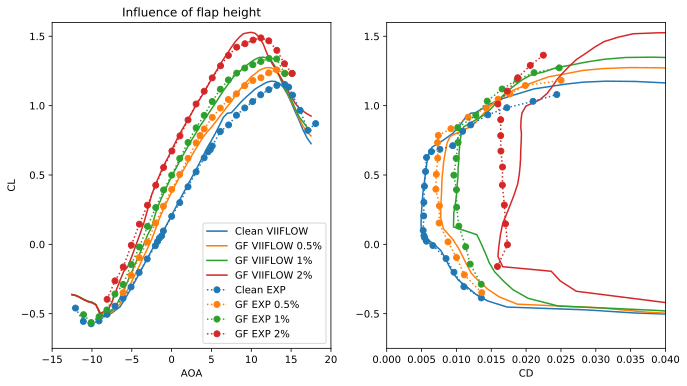

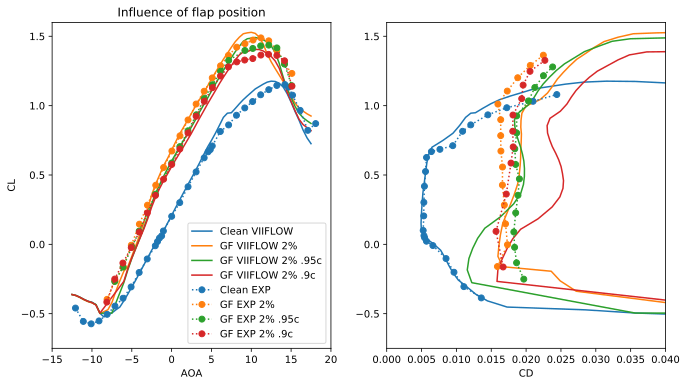

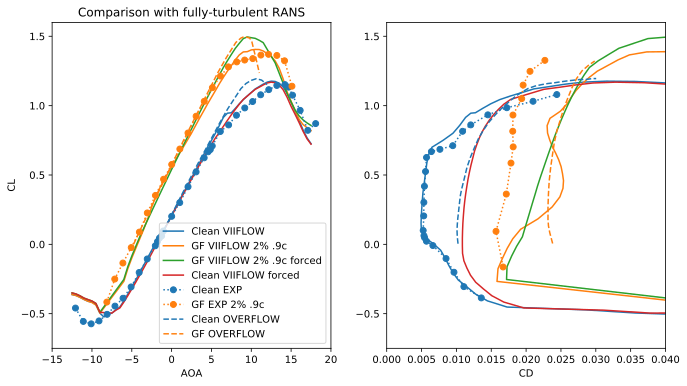

In [9]:
matplotlib.rcParams['figure.figsize'] = [11, 6]
fig,ax = plt.subplots(1,2)
cmap = plt.get_cmap("tab10")


# Part one, influence of height
namesVF = ['Clean VIIFLOW','GF VIIFLOW 0.5%','GF VIIFLOW 1%','GF VIIFLOW 2%',\
          'GF VIIFLOW 2% .95c','GF VIIFLOW 2% .9c',\
          'GF VIIFLOW 2% .9c forced','Clean VIIFLOW forced']
for k in range(4):
    ax[0].plot(pol[k]['al'],pol[k]['CL'],'-',color=cmap(k),label = namesVF[k])
    ax[1].plot(pol[k]['CD']*1+1*(pol[k]['CDg']),pol[k]['CL'],color=cmap(k))


namesEXP = ['Clean EXP','GF EXP 0.5%','GF EXP 1%','GF EXP 2%','GF EXP 2% .95c',\
            'GF EXP 2% .9c']
for k in range(4):
    Data = np.genfromtxt('S903GurneyCL.csv',skip_header=1,delimiter=",",usecols=[2*k,2*k+1])
    ax[0].plot(Data.T[0],Data.T[1],':o',color = cmap(k),label = namesEXP[k])
    Data = np.genfromtxt('S903GurneyPolar.csv',skip_header=1,delimiter=",",usecols=[2*k,2*k+1])
    ax[1].plot(Data.T[0],Data.T[1],':o',color = cmap(k))

ax[0].legend()
ax[0].set_xlim(-15,20)
ax[1].set_xlim(0,0.04)
ax[1].set_ylim(-.75,1.6)
ax[0].set_ylim(-.75,1.6)
ax[0].set_xlabel('AOA')
ax[0].set_ylabel('CL')
ax[1].set_xlabel('CD')
ax[0].set_title('Influence of flap height')


# Part two, influence of chord position
fig,ax = plt.subplots(1,2)
kcol = 0
for k in [0,3,4,5]:
    ax[0].plot(pol[k]['al'],pol[k]['CL'],'-',color=cmap(kcol),label = namesVF[k])
    if k>3: useg=0
    else: useg=1
    ax[1].plot(pol[k]['CD']*1+useg*pol[k]['CDg'],pol[k]['CL'],color=cmap(kcol))
    kcol+=1

kcol = 0
for k in [0,3,4,5]:
    Data = np.genfromtxt('S903GurneyCL.csv',skip_header=1,delimiter=",",usecols=[2*k,2*k+1])
    ax[0].plot(Data.T[0],Data.T[1],':o',color = cmap(kcol),label = namesEXP[k])
    Data = np.genfromtxt('S903GurneyPolar.csv',skip_header=1,delimiter=",",usecols=[2*k,2*k+1])
    ax[1].plot(Data.T[0],Data.T[1],':o',color = cmap(kcol))
    kcol+=1

ax[0].legend()
ax[0].set_xlim(-15,20)
ax[1].set_xlim(0,0.04)
ax[1].set_ylim(-.75,1.6)
ax[0].set_ylim(-.75,1.6)
ax[0].set_xlabel('AOA')
ax[0].set_ylabel('CL')
ax[1].set_xlabel('CD')#
ax[0].set_title('Influence of flap position')

# Part three, comparison with fully-turbulent RANS
fig,ax = plt.subplots(1,2)
kcol = 0
for k in [0,5,6,7]:
    ax[0].plot(pol[k]['al'],pol[k]['CL'],'-',color=cmap(kcol),label = namesVF[k])
    if k>3: useg=0
    else: useg=1
    ax[1].plot(pol[k]['CD']*1+useg*pol[k]['CDg'],pol[k]['CL'],color=cmap(kcol))
    kcol+=1
    
kcol = 0
for k in [0,5]:
    Data = np.genfromtxt('S903GurneyCL.csv',skip_header=1,delimiter=",",usecols=[2*k,2*k+1])
    ax[0].plot(Data.T[0],Data.T[1],':o',color = cmap(kcol),label = namesEXP[k])
    Data = np.genfromtxt('S903GurneyPolar.csv',skip_header=1,delimiter=",",usecols=[2*k,2*k+1])
    ax[1].plot(Data.T[0],Data.T[1],':o',color = cmap(kcol))
    kcol+=1

# Add CDF results from thesis
names = ['Clean Exp','Clean OVERFLOW','GF Exp','GF OVERFLOW']
linestyle = ['--o','--','--o','--']
colors = [cmap(0),cmap(0),cmap(1),cmap(1)]
for k in [1,3]:
    Data = np.genfromtxt('GurneyS903Lift.csv',skip_header=1,delimiter=",",usecols=[2*k,2*k+1])
    ax[0].plot(Data.T[0],Data.T[1],linestyle[k],color = colors[k],label = names[k])
    Data = np.genfromtxt('GurneyS903Polar.csv',skip_header=1,delimiter=",",usecols=[2*k,2*k+1])
    ax[1].plot(Data.T[0],Data.T[1],linestyle[k],color = colors[k],label = names[k])

ax[0].legend()
ax[0].set_xlim(-15,20)
ax[1].set_xlim(0,0.04)
ax[1].set_ylim(-.75,1.6)
ax[0].set_ylim(-.75,1.6)
ax[0].set_xlabel('AOA')
ax[0].set_ylabel('CL')
ax[1].set_xlabel('CD')
ax[0].set_title('Comparison with fully-turbulent RANS');

## Pressure Distribution
In [7] the pressure coefficients over the airfoil surface is given for a lift coefficient of 0.7.
The effect of the Gurney flap on the pressure is well predicted.
For the 1c Gurney flap, the step in pressure at the trailing edge smaller in the simulations, but the global pressure distribution matches well.
For the .9c configuration the step matches quite well, but the decrease in speed before the flap is underpredicted.

The transition seems to occur rather sooner on the suction side in the experiments.
In fact, it seems to occur around .05c regardless of Gurney flap position (though it should be a pressure distribution without forced transition), but maybe something else is going at this location.
On the pressure side, the transition does not seem to occur as suddenly as it occurs in the simulations.
This may explain the difference in surface speed in the .9c configuration.

 xi=0.058201,delta=0.000143,theta=0.000143,ue=1.447258,typ=wake,
 res=-1.72691e-07--1.53733e-07--8.51451e-11, dx=5.16696e-11--8.11001e-08--5.49918e-09 lam=0.000000, US=0.999998,HK=1.000001,HS=1.999999.

 xi=0.063915,delta=0.000135,theta=0.000135,ue=1.675570,typ=wake,
 res=-1.14199e-07--1.04265e-07--5.19218e-11, dx=3.56439e-11--7.72543e-08--3.95171e-09 lam=0.000000, US=0.999998,HK=1.000001,HS=1.999999.

 xi=0.058201,delta=0.000197,theta=0.000197,ue=1.693442,typ=wake,
 res=-4.73862e-07--1.85462e-07--7.57422e-11, dx=8.464e-11-4.28627e-08--5.7349e-09 lam=0.000000, US=0.999998,HK=1.000001,HS=1.999999.

 xi=0.099884,delta=0.000124,theta=0.000124,ue=2.243668,typ=wake,
 res=-7.89237e-09--8.8972e-09--8.91942e-13, dx=3.23554e-12--1.35507e-08--3.47454e-10 lam=0.000000, US=0.999998,HK=1.000001,HS=1.999999.

 xi=0.956905,delta=0.002202,theta=0.001294,ue=0.791638,typ=turbulent,
 res=-0.109255-0.0140617-0.000426647, dx=-0.00150486-0.292725--0.0474135 lam=0.286592, US=0.420726,HK=1.701914,HS=1.672533.

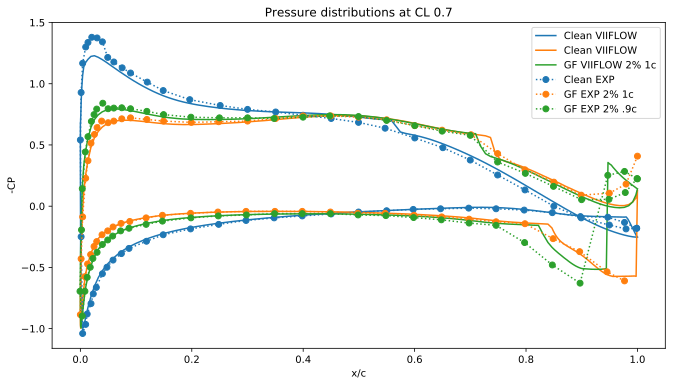

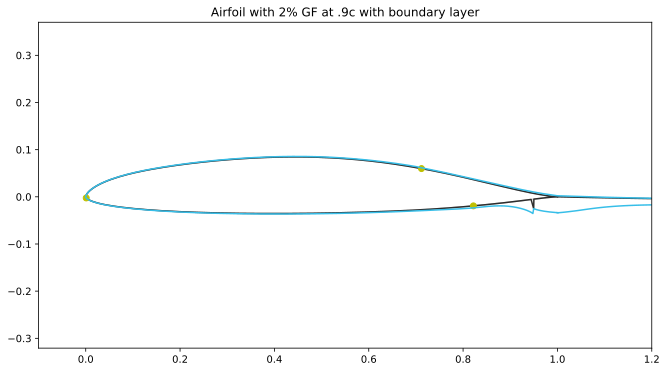

In [15]:
# Pressure comparison
hgv = [0.0,0.02,0.02]
pchord = [1,1,0.95]
alphas = [4.5,0.1,1.0] # ->CL=0.7, read form above

fig,ax = plt.subplots(1,1)
names = ['Clean VIIFLOW','Clean VIIFLOW', 'GF VIIFLOW 2% 1c','GF VIIFLOW 2% .9c']
for k in range(len(hgv)):
    hg = hgv[k] 
    pc = pchord[k]
    alpha = alphas[k]
    
    vd = 0*AF[0,:]

    if pc>=1.0:
        index_gf = N-1
    else:
        for j in range(1,AF.shape[1]):
            if AF[0,-j]<pc:
                index_gf = N-j
                break
    vd[index_gf] = hg
    
    s.alpha = alpha
    s.itermax = 100
    s.iterate_wakes = False
    (p0,bl0,x0) = vf.init(AF,s)
    if hg>0:
        xtrans = p.foils[0].X[0,index_gf]-0.01
        vf.set_forced_transition(bl0,p0,[],[xtrans])
    [x,flag,res,grad,_] = vf.iter(x0,bl0,p0,s,None,None,[vd])

    plt.plot(p.foils[0].X[0,:],np.power(p0.gamma_viscid[0:p0.foils[0].N],2)-1,label=names[k])

names = ['Clean EXP', 'GF EXP 2% 1c','GF EXP 2% .9c']
for k in range(3):
    Data = np.genfromtxt('S903GurneyCP.csv',skip_header=1,delimiter=",",usecols=[2*k,2*k+1])
    ax.plot(Data.T[0],Data.T[1],':o',color = cmap(k),label = names[k])
ax.legend()
ax.set_xlabel('x/c')
ax.set_ylabel('-CP')
ax.set_title('Pressure distributions at CL 0.7')

fig,ax = plt.subplots(1,1)
lines = vfp.plot_geometry(ax,p0,bl0,None);
ax.set_title('Airfoil with 2% GF at .9c with boundary layer');

[1] Liu, Tianshu, and Javier Montefort. "Thin-airfoil theoretical interpretation for Gurney flap lift enhancement." Journal of Aircraft 44.2 (2007): 667-671.

[2] Jeffrey, David, Xin Zhang, and David W. Hurst. "Aerodynamics of Gurney flaps on a single-element high-lift wing." Journal of Aircraft 37.2 (2000): 295-301.

[3] Troolin, D. R., E. K. Longmire, and W. T. Lai. "Time resolved PIV analysis of flow over a NACA 0015 airfoil with Gurney flap." Experiments in Fluids 41.2 (2006): 241-254.

[4] Coder, James George. "CFD Investigation of Unsteady Rotorcraft Airfoil Aerodynamics." (2010).

[5] Storms, Bruce L., and Cory S. Jang. "Lift enhancement of an airfoil using a Gurney flap and vortex generators." Journal of Aircraft 31.3 (1994): 542-547.

[6] Jeffrey, David, Xin Zhang, and David W. Hurst. "Aerodynamics of Gurney flaps on a single-element high-lift wing." Journal of Aircraft 37.2 (2000): 295-301.

[7] Maughmer, Mark D., and Götz Bramesfeld. "Experimental investigation of Gurney flaps." Journal of Aircraft 45.6 (2008): 2062-2067.

[8] Somers, Dan M. "Effects of Airfoil Thickness and Maximum Lift Coefficient on Roughness Sensitivity: 1997--1998." No. NREL/SR-500-36336. National Renewable Energy Lab., Golden, CO (US), 2005.